# Machine Analysis Primer For b278 5k VVV Tile

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [1]:
% matplotlib inline

import os
import tempfile

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d

from lime import lime_tabular as lt

from joblib import Memory

from libs import container

pd.options.mode.chained_assignment = None 

memory = Memory(cachedir="cache", verbose=0)

## 1. Load Data

In [2]:
path = "/home/data/carpyncho/stored/samples/5k/"
data = container.read(path)

print("Removing b220...")
del data["b220"]

Loading '/home/data/carpyncho/stored/samples/5k/b278_sample_5k.npy'...
Loading '/home/data/carpyncho/stored/samples/5k/b262_sample_5k.npy'...
Loading '/home/data/carpyncho/stored/samples/5k/b261_sample_5k.npy'...
Loading '/home/data/carpyncho/stored/samples/5k/b263_sample_5k.npy'...
Loading '/home/data/carpyncho/stored/samples/5k/b220_sample_5k.npy'...
Loading '/home/data/carpyncho/stored/samples/5k/b264_sample_5k.npy'...
Removing b220...


##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
classes = set()
for df in data.values():
    classes.update(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

for df in data.values():
    df["cls"] = df.ogle3_type.apply(classes.get)
    df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

### Simplified Classes

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

### 2.2. Removes all low-variance and "bad" features

In [4]:
df = data.b278
X_columns = df.columns[~df.columns.isin(["id", "cls", "scls", "ogle3_type"])]
print("Raw Features:", X_columns.size)

# remove signatures
X_columns = X_columns[~X_columns.str.startswith("Signature_")]
X_columns

# columns with nan and null
with_nulls = set()
for df in data.values():
    for c in X_columns:
        if df[c].isnull().any():
            with_nulls.add(c)
X_columns = X_columns[~X_columns.isin(with_nulls)]

# low variance
df = pd.concat(data.values())
y = df["cls"].values

vt = fs.VarianceThreshold()
vt.fit(df[X_columns].values, y)
X_columns = X_columns[vt.get_support()]

print("Total features:", X_columns.size)

del df, y

('Raw Features:', 60)
('Total features:', 54)


### 2.3 Selected features

In [5]:
d.display(d.HTML(
    "<ol>" +
    "".join("<li>{}</li>".format(c) for c in X_columns) +
    "</ol>"))

## 3. Machine Learning

The next function fit the classifier with kfolds (`default=10`) print a and retrieve:

- **fpr:** False positive rates
- **tpr:** True positive rates
- **thresh:** Decreasing thresholds on the decision function used to compute fpr and tpr
- **roc_auc:** Area under curve of ROC Curve.
- **y_test:** Array of all classes of testing samples.
- **predictions:** The prediction clases for the testing samples.
- **probabilities:** Predicted classes probabilities for tests.
- **confussion_matrix:** Confusion matrix to evaluate the accuracy of a classification

In [6]:
@memory.cache
def experiment(clf, data, train_name, test_name, pcls):
    
    original_clf = clf
    clf = sklearn.clone(original_clf)
    
    train_df, test_df = data[train_name], data[test_name]
    
    cfilter = [sclasses[pcls], sclasses[""]]
    
    train_df = train_df[train_df.scls.isin(cfilter)]
    test_df = test_df[test_df.scls.isin(cfilter)]
    
    x_train = prp.StandardScaler().fit_transform(
        train_df[X_columns].values)
    y_train = train_df["scls"]

    x_test = prp.StandardScaler().fit_transform(
        test_df[X_columns].values)
    y_testing = test_df["scls"]
    
    clf.fit(x_train, y_train)

    predictions = clf.predict(x_test)
    probabilities = clf.predict_proba(x_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_testing, 1.-probabilities[:,0], pos_label=cfilter[0])
    prec_rec_curve = metrics.precision_recall_curve(
        y_testing, 1.- probabilities[:,0], pos_label=cfilter[0])
    roc_auc = metrics.auc(fpr, tpr)

    return container.Container({
            'test_name': test_name,
            'train_name': train_name,
            'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions)})


def experiments(clf, data, train_name, pcls, verbose=True):
    results = []
    for test_name in data.keys():
        if test_name != train_name:
            rst = experiment(clf, data, train_name, test_name, pcls)
            results.append(rst)
            if verbose:
                print "{} (TRAIN) Vs. {} (TEST)".format(rst.train_name, rst.test_name)
                print metrics.classification_report(rst.y_test, rst.predictions)
                print "-" * 80
    return tuple(results)


def roc(results):
    cmap = cm.get_cmap("plasma")
    colors = iter(cmap(np.linspace(0, 1, len(results))))

    for res  in results:
        cname = "Vs.{}".format(res.test_name)
        color = next(colors)
        label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
        plt.plot(res["fpr"], res["tpr"], color=color, label=label)

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def resume(label, results, rfunc):
    slice = np.min([r.fpr.size for r in results])
    mfpr = rfunc(np.vstack([r.fpr[:slice] for r in results]), axis=0)
    mtpr = rfunc(np.vstack([r.tpr[:slice] for r in results]), axis=0)
    roc_auc = rfunc([r.roc_auc for r in results])
    return container.Container(test_name=label, fpr=mfpr, tpr=mtpr, roc_auc=roc_auc)

### 3.1. SVM - Linear

Execute a **SVM** with a **linear kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      5000
          3       0.86      0.68      0.76       297

avg / total       0.97      0.98      0.97      5297

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      5000
          3       0.88      0.65      0.75       308

avg / total       0.97      0.97      0.97      5308

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5000
          3       0.80      0.74      0.77       222

avg / total       0.98      0.98      0.98      5222

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

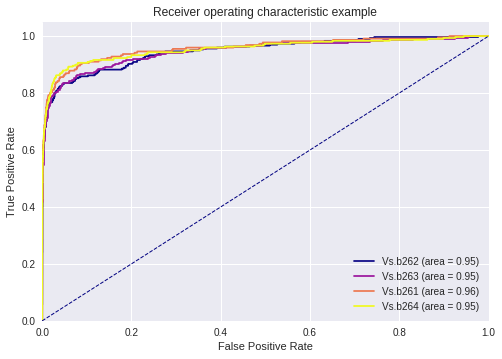

In [7]:
svc_linear = experiments(svm.SVC(kernel='linear', probability=True), data, "b278", "RRLyr")
roc(svc_linear)

### 3.2 SVM - Polynomic

Execute a **SVM** with a **polynomic kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      5000
          3       0.80      0.58      0.68       297

avg / total       0.97      0.97      0.97      5297

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      5000
          3       0.81      0.54      0.65       308

avg / total       0.96      0.97      0.96      5308

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      5000
          3       0.80      0.61      0.69       222

avg / total       0.97      0.98      0.98      5222

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

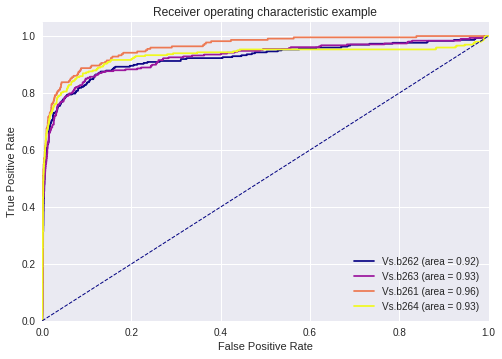

In [8]:
%time svc_poly = experiments(svm.SVC(kernel='poly', probability=True), data, "b278", "RRLyr")
roc(svc_poly)

### 3.3. Random Forest

Execute a **Random Forest** with **500 c45** trees. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      5000
          3       0.96      0.63      0.76       297

avg / total       0.98      0.98      0.98      5297

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      5000
          3       0.96      0.64      0.77       308

avg / total       0.98      0.98      0.98      5308

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      5000
          3       0.94      0.71      0.81       222

avg / total       0.99      0.99      0.98      5222

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

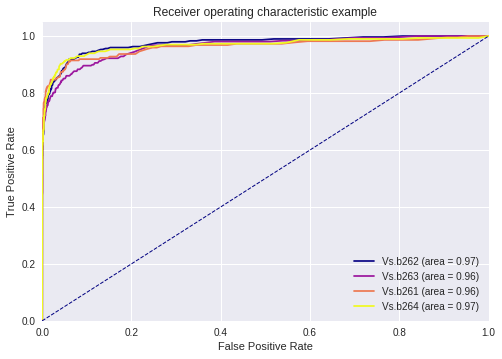

In [9]:
%time rf = experiments(RandomForestClassifier(n_estimators=500, criterion="entropy"), data, "b278", "RRLyr")
roc(rf)

### 3.4. KNN

KNN with **3** neightbors ad weights determined by the **distance**. Docs: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      5000
          3       0.84      0.55      0.66       297

avg / total       0.97      0.97      0.97      5297

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      5000
          3       0.88      0.49      0.63       308

avg / total       0.96      0.97      0.96      5308

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      5000
          3       0.84      0.59      0.70       222

avg / total       0.98      0.98      0.98      5222

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

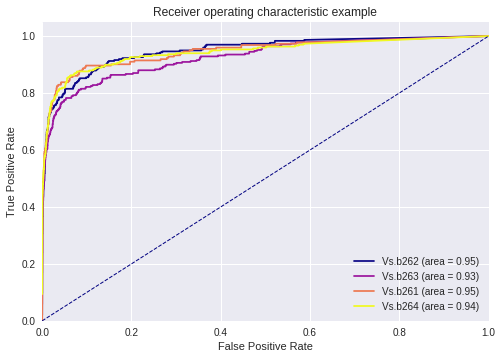

In [10]:
%time knn = experiments(KNeighborsClassifier(n_neighbors=50, weights='distance'), data, "b278", "RRLyr")
roc(knn)